1. Convolutional layers with Batch Normalization and Dropout.
2. Attention Mechanism: We'll integrate a basic channel-wise attention mechanism.
3. Advanced layers: Using layers like Separable Convolutions, and GlobalAveragePooling for more efficient feature extraction.

In [1]:
# lib's
import os
import glob

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.preprocessing import image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

# Custom Channel-wise Attention Mechanism
class ChannelAttention(layers.Layer):
#     def __init__(self, channels, reduction_ratio=8):
#         super(ChannelAttention, self).__init__()
#         self.channels = channels
#         self.reduction_ratio = reduction_ratio
#         self.global_avg_pool = layers.GlobalAveragePooling2D()
#         self.global_max_pool = layers.GlobalMaxPooling2D()
        
#         self.fc1 = layers.Dense(channels // reduction_ratio, activation='relu')
#         self.fc2 = layers.Dense(channels)
        
#     def call(self, inputs):
#         avg_pool = self.global_avg_pool(inputs)
#         max_pool = self.global_max_pool(inputs)
        
#         avg_pool = layers.Reshape((1, 1, self.channels))(avg_pool)
#         max_pool = layers.Reshape((1, 1, self.channels))(max_pool)
        
#         avg_fc = self.fc2(self.fc1(avg_pool))
#         max_fc = self.fc2(self.fc1(max_pool))
        
#         attention = layers.Activation('sigmoid')(avg_fc + max_fc)
        
#         return inputs * attention
    
    def __init__(self, reduction_ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.dense1 = tf.keras.layers.Dense(input_shape[-1] // self.reduction_ratio, activation='relu')
        self.dense2 = tf.keras.layers.Dense(input_shape[-1])

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        
        avg_out = self.dense2(self.dense1(avg_pool))
        max_out = self.dense2(self.dense1(max_pool))
        
        scale = tf.nn.sigmoid(avg_out + max_out)
        return inputs * scale

    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({"reduction_ratio": self.reduction_ratio})
        return config
    

# Custom CNN with Attention
def custom_cnn_with_attention(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Block 1: Convolutional block with Attention
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = ChannelAttention(32)(x)                                                 # Attention applied here
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 2: Advanced Convolutional Block (Separable Conv)
    x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = ChannelAttention(64)(x)                                                 # Attention applied here
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Block 3: Deeper Conv Block with Global Pooling
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = ChannelAttention(128)(x)                                                # Attention applied here
    
    # Global Average Pooling and Fully Connected Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Exanple use
# # Model Compilation and Summary
# input_shape = (128, 128, 3)  # Example input shape
# num_classes = 10  # Example number of output classes

# model = custom_cnn_with_attention(input_shape, num_classes)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()


In [3]:
# Step 1: Define the paths for training and validation data
train_data_dir = os.path.join('..', 'Dataset', 'data', 'train')  # Root folder that contains subfolders '0', '1', '2'
test_data_dir = os.path.join('..', 'Dataset', 'data', 'test')  # Root folder that contains subfolders '0', '1', '2'

# Step 2: ImageDataGenerator for loading and augmenting images
# You can apply real-time augmentation if needed
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    zoom_range = 0.1
)
test_datagen = ImageDataGenerator(rescale = 1./255 )

# Step 3: Load training data (80%) and validation data (20%)
# The flow_from_directory function will infer the labels based on the folder names
train_generator = train_datagen.flow_from_directory(
    directory = train_data_dir,
    target_size = (128, 128),  # Resize all images to the input shape expected by the model
    batch_size = 32,
    class_mode = 'categorical'  # For multi-class classification
)

validation_generator = test_datagen.flow_from_directory(
    directory = test_data_dir,
    target_size = (128, 128),  # Resize all images to the input shape expected by the model
    batch_size = 32,
    class_mode = 'categorical'  # For multi-class classification
)


Found 1206 images belonging to 3 classes.
Found 594 images belonging to 3 classes.


In [4]:
checkpoint_dir = 'checkpoints_CNN_attention_mechanisms_adam'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir,
                                   "model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}_val_loss_{val_loss:.2f}.keras")

checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                             monitor = 'val_loss',
                             verbose = 0,
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'auto')

early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0,
                      patience = 10,
                      verbose = 0,
                      mode = 'auto')

reduceLR = ReduceLROnPlateau(monitor = "val_loss", 
                             factor = 0.1,
                             patience = 5, 
                             verbose = 0, 
                             mode = "auto",
                             min_delta = 0.0001, 
                             cooldown = 0,
                             min_lr = 0.0)

csv_logger = CSVLogger('training.log')

callbacks_list = [checkpoint, reduceLR, csv_logger] #, early

In [13]:
# # Step 4: Create the Custom CNN model with Attention Mechanisms
input_shape = (128, 128, 3)  # Image shape
num_classes = len(glob.glob(os.path.join(train_data_dir, '*'))) # 3
model = custom_cnn_with_attention(input_shape, num_classes)

# Step 5: Compile the model
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

# Step 6: Train the model
history = model.fit(
    train_generator,  # Training data
    epochs = 100,  # Number of epochs
    validation_data = validation_generator,  # Validation data
    callbacks = callbacks_list
)

# Optional: Save the trained model
save_model_path = os.path.join(checkpoint_dir, 'custom_cnn_attention_model.h5')
model.save(save_model_path)
print(f"Model saved as {save_model_path}.")





Epoch 1/100





KeyboardInterrupt



In [ ]:
# accuracies
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.savefig('CNN_with_attention_mechanisms_adam_model_accuracy_and_val_accuracy.png', dpi=200)
plt.show()
 
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('CNN_with_attention_mechanisms_adam_model_loss_and_val_loss.png', dpi=200)
plt.show()

In [ ]:
# Evaluate the model using validation data
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

In [ ]:
val_data_dir = os.path.join('..', 'Dataset', 'data', 'val')

val_datagen = ImageDataGenerator(rescale = 1./255 )

val_generator = val_datagen.flow_from_directory(
    directory = val_data_dir,
    target_size = (128, 128),  # Resize all images to the input shape expected by the model
    batch_size = 32,
    class_mode = 'categorical'  # For multi-class classification
)

loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


In [ ]:
# score = model.evaluate(train_generator, verbose=0)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])

# score = model.evaluate(validation_generator, verbose=0)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])

# score = model.evaluate(validation_generator, verbose=0)
# print('Train loss:', score[0])
# print('Train accuracy:', score[1])

In [7]:
# !pip install pydot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

model_path = os.path.join(checkpoint_dir, 'custom_cnn_attention_model.h5')
custom_objects = {'ChannelAttention': ChannelAttention}
model = load_model(model_path, custom_objects=custom_objects)

In [ ]:
# !pip uninstall pydot graphviz
# !pip install pydot==1.4.2 graphviz==0.16

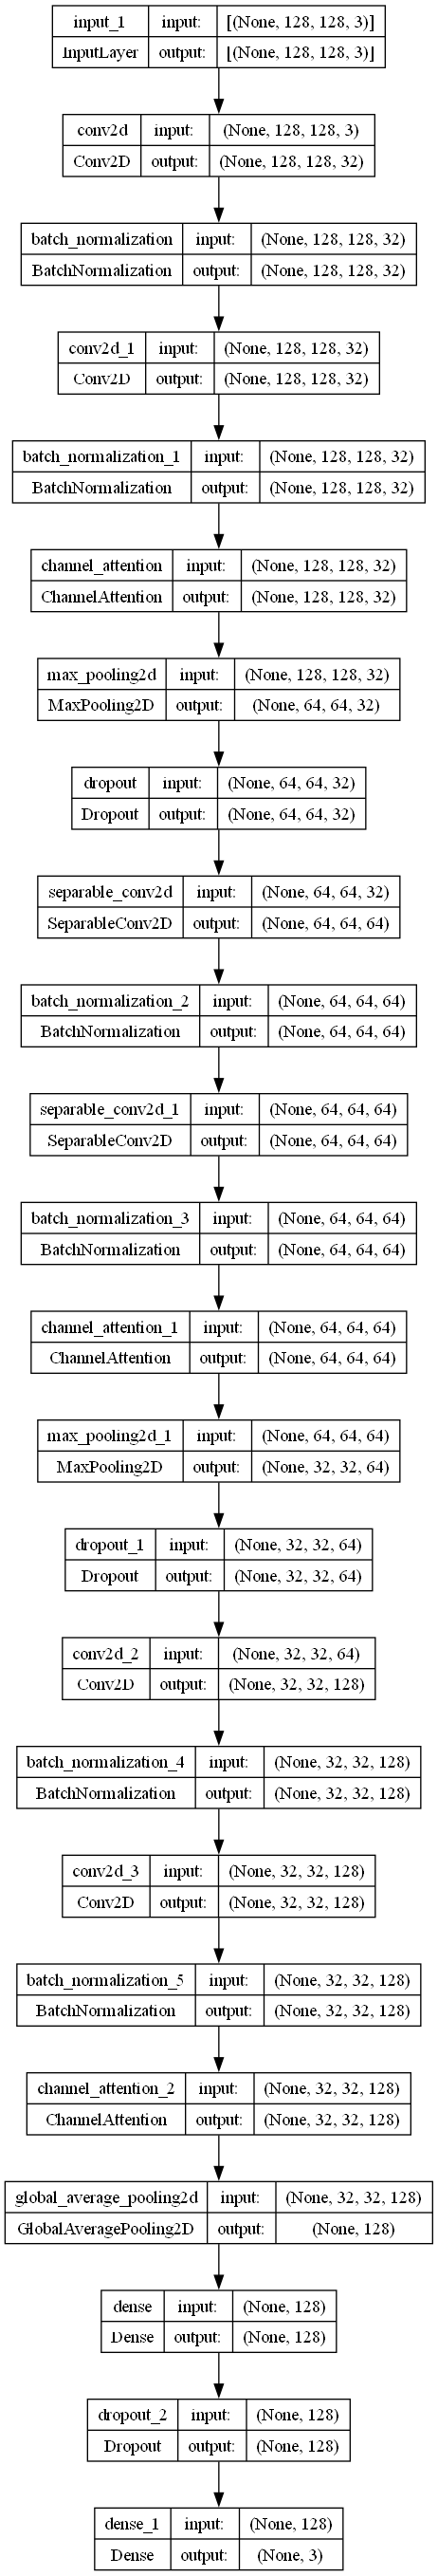

In [8]:
# !pip install pydot graphviz
from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the saved model
from IPython.display import Image
Image(filename='model_architecture.png')

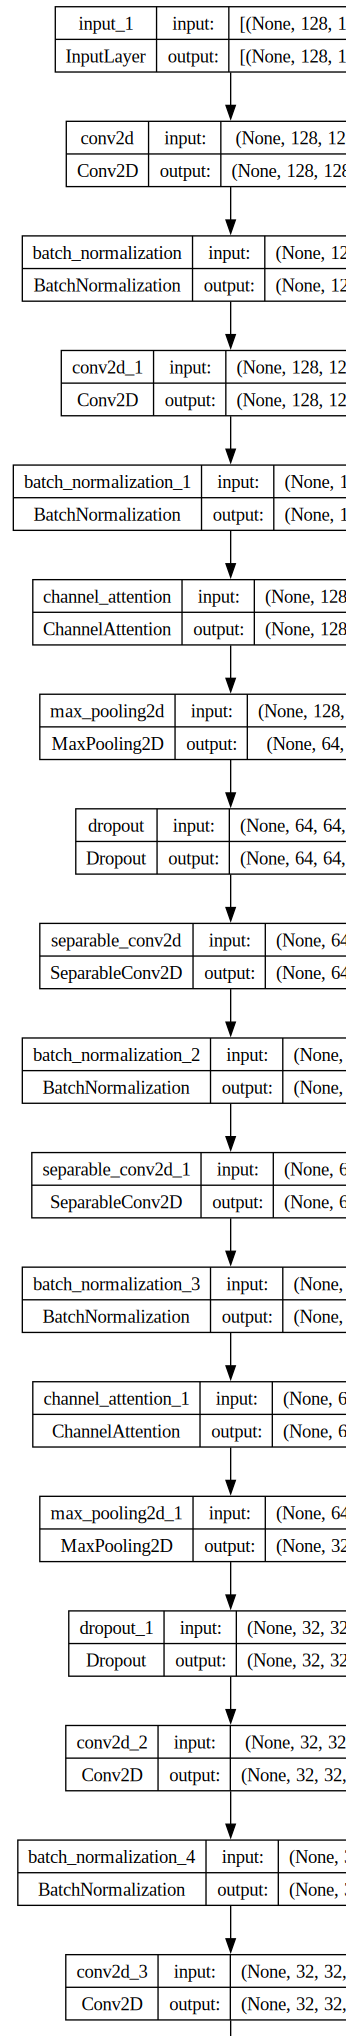

In [9]:

# Show the model in SVG format directly in the notebook
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

# Create Classification Report

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [ ]:
# Create Classification Report

def evaluate_model(y_true, y_pred, class_names=None):
    """
    This function evaluates the performance of a model and prints the confusion matrix, 
    accuracy score, classification report, and Cohen's kappa score. It also plots a heatmap of the confusion matrix.
    
    Args:
        y_true (array-like): Ground truth (true labels)
        y_pred (array-like): Predicted labels from the model
        class_names (list): List of class names for better readability in the confusion matrix
        
    Returns:
        None: Displays the evaluation metrics and heatmap.
    """
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_true, y_pred)
    
    # Get classification report
    class_report = classification_report(y_true, y_pred, target_names=class_names)
    
    # Calculate Cohen's kappa score
    kappa_score = cohen_kappa_score(y_true, y_pred)
    
    # Print evaluation metrics
    print("Confusion Matrix:\n", cm)
    print(f"\nAccuracy Score: {accuracy * 100:.2f}%")
    print("\nClassification Report:\n", class_report)
    print(f"Cohen's Kappa Score: {kappa_score:.4f}")
    
    # Plot heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


def create_classification_report(model_path, test_data_dir):
    # Step 1: Set up directories and parameters
    # test_data_dir = 'data/train/'  # Path to the directory containing test images in folders 0, 1, 2

    # Step 2: Load the trained model
    # Ensure ChannelAttention is defined
    custom_objects = {
        'ChannelAttention': ChannelAttention
    }
    model = load_model(model_path, custom_objects=custom_objects)  # Assuming you've saved the model as .h5

    # Step 3: ImageDataGenerator for loading test images (no augmentation needed for testing)
    test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]

    # Step 4: Load test data using flow_from_directory
    test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size = (128, 128),  # Same size as the input size for your model
        batch_size = 32,  # Adjust according to your hardware
        class_mode = 'categorical',  # For multi-class classification
        shuffle = False  # Don't shuffle, we need to keep track of the order for y_true
    )

    # Step 5: Get true labels from the generator
    y_true = test_generator.classes  # These are the true class labels

    # Step 6: Predict using the model
    y_pred_prob = model.predict(test_generator)  # Predict probabilities for each class
    y_pred = np.argmax(y_pred_prob, axis=1)  # Get the index of the max probability (class label)

    # Step 7: Map predicted and true labels to class names
    class_labels = list(test_generator.class_indices.keys())

    # Optional: Display the first few true and predicted labels
#     print("True Labels:", y_true[:5])
#     print("Predicted Labels:", y_pred[:5])

    # Now y_true contains the true labels and y_pred contains the predicted labels

#     # Step 8: Evaluate the model    
#     accuracy = accuracy_score(y_true, y_pred)
#     print(f"Accuracy: {accuracy * 100:.2f}%")

#     print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

#     cm = confusion_matrix(y_true, y_pred)
#     print("\nConfusion Matrix:\n", cm)

    # Optional: You can use the evaluation function from earlier for further analysis
    evaluate_model(y_true, y_pred, class_names=class_labels)
    
# Call the function

model_path = os.path.join('checkpoints_CNN_attention_mechanisms_adam', 'custom_cnn_attention_model.h5')
test_data_dir = os.path.join('..', 'Dataset', 'data', 'val')

create_classification_report(model_path, test_data_dir)